## Import packages

First import packages that are needed.

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

## Dataset

Then build cifar10 dataset. Since the original image pixels are denoted by integers, we normalize them with mean value 0.5 for each channel.

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Dataloader

Use the default dataloader with batch size 4.

In [3]:
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=4)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=4)

## Visualization

Until now we have build datasets and dataloaders. Let's visualize some pictures in the dataset.

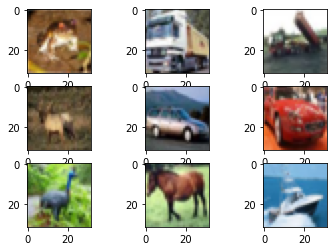

In [4]:
import numpy as np
for i in range(9):
    img, _ = trainset[i]
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.subplot(3,3,i+1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

plt.show()

## Model

Now we build a model consists of convolutional layers and linear layers.

In [5]:
import torch.nn.functional as F
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 8 * 8, 40)
        self.fc2 = nn.Linear(40, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 8 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1)

        return x


net = Net()

## Loss function & optimizer

After building the model, we need a loss function to compute loss. And a optimizer to update the model.

In [7]:
import torch.optim as optim

loss_func = nn.CrossEntropyLoss()
loss_func.to('cuda')
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(net.parameters())

## Training

Now we have datasets, model, loss function and optimizer, we train the model for 3 epochs.

In [8]:
num_epochs = 3
bs = 4
print_steps = 2000
net.to('cuda')
for epoch in range(num_epochs):
    running_loss = 0
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % print_steps == print_steps-1:
            print('[%d %5d]: loss: %.4f'%(epoch + 1, i + 1, running_loss/print_steps))
            running_loss = 0
            

[1  2000]: loss: 2.1766
[1  4000]: loss: 2.1137
[1  6000]: loss: 2.0738
[1  8000]: loss: 2.0454
[1 10000]: loss: 2.0409
[1 12000]: loss: 2.0290
[2  2000]: loss: 2.0099
[2  4000]: loss: 1.9989
[2  6000]: loss: 1.9750
[2  8000]: loss: 1.9810
[2 10000]: loss: 1.9891
[2 12000]: loss: 1.9802
[3  2000]: loss: 1.9674
[3  4000]: loss: 1.9665
[3  6000]: loss: 1.9548
[3  8000]: loss: 1.9477
[3 10000]: loss: 1.9685
[3 12000]: loss: 1.9537


## test

Compute the accuracy of test dataset to measure the performance of the model.

In [15]:
def validate(dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            outputs = net(images.to('cuda'))
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.to('cuda')
            labels = labels.to('cuda')
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the dataset: %.1f %%' % (100.0 * correct / total))
    
validate(test_dataloader)

Accuracy of the dataset: 51.4 %


## Prediction

In [18]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

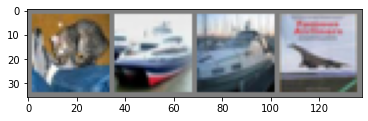

Label:    cat  ship  ship plane
Prediction:    cat plane  ship  ship


In [31]:
images = []
labels = []
for i in range(4):
    images.append(testset[i][0])
    labels.append(testset[i][1])
images = torch.stack(images)
imshow(torchvision.utils.make_grid(images))
print('Label: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(images.to('cuda:0'))
_, pred = torch.max(outputs.data, 1)
print('Prediction: ', ' '.join('%5s' % classes[pred[j]] for j in range(4)))